In [1]:
# Author: Claudia Falsetti <1431314>
# Python 3.7.3 

import pandas as pd 
from nltk.corpus import stopwords, words, wordnet 
from gensim import corpora, models, similarities
from string import punctuation, digits
from collections import Counter, defaultdict
import re 
import numpy as np 
import csv 
import string 
from nltk.stem import WordNetLemmatizer 
import nltk 

from gensim import corpora, models, similarities
import pyLDAvis.gensim
import numpy as np 
from time import time 
import pickle 


In [2]:
def get_non_aggregated_docs(filename):
    data_frame = pd.read_csv(filename, names = ["TweetID", "Username", "Text"])
    df = data_frame.sort_values(by = "TweetID").drop_duplicates("Text")
    tweets = df['Text'].tolist()
    #tweets = ' '.join(tweets)
    
    return tweets

def delete_duplicate_tweets(filename):
    data_frame = pd.read_csv(filename)
    data_frame.columns = ['TweetID', 'Username', 'Text']
    df = data_frame.sort_values(by='Username').drop_duplicates('Text')
    
    return df 


def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize()
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_non_aggregated_tweets(documents):
    '''
    Function that lowercases the text and clean it
    Iterates over every tweet in the corpus and breaks the tweets into tokens
    It then removes punctuations, special characters and stopwords. 
    It takes as input the collections of tweets as a list and outputs 
    a list of preprocessed tweets 
    '''
    
    lemmatizer = WordNetLemmatizer()
    lemmas = set(wordnet.all_lemma_names())
    
    stop_words = stopwords.words('english')
    
    stoplist_extra=['amp','youd', 'wed' ,'id', 'get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
                    'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via', 'seven', 'eight', 'nine', 
                    'ten','one','com','new','like','great','make','top','good','wow','yes','say','yay','would',
                    'thanks','thank','going', 'new','use','should','could','best','really','see','want','nice',
                    'shes', 'hes ', 'were', 'theyre', 'yous','two', 'three','four', 'five', 'six', 'while',
                    'know', 'ngl', 'brb', 'acc', 'smh', 'fwiw', 'ftl','lmao', 'lol', 'omg', 'https', 'mvp', 
                    'isnt', 'arent', 'ever','cant', 'hnd', 'sbe', 'gsa', 'bwr', 'yeah', 'fuck', 'torture',
                    'shit','say', 'try', 'well', 'take', 'way', 'many', 'yet','never', 'may', 'come', 
                    'actually', 'much', 'thing', 'year', 'month','people', 'also', 'around', 'think', 
                    'keep', 'time', 'someone', 'give', 'back', 'need', 'time', 'feel', 'look', 'even',
                    'start', 'every', 'tell', 'first', 'lot', 'sure', 'though', 'end', 'still', 'bitch',
                    'wait', 'watch', 'already', 'always', 'thought','right', 'call', 'put', 'long',
                    'mak', 'cunt', 'aku', 'dia', 'yang','dah', 'masa', 'lepas', 'dari','joseph', 
                    'miller', 'ada', 'orang', 'kat', 'lah','zaman','gila','akan','tau','salah','mak',
                    'kali','ali', 'susah','lama','bahasa', 'het', 'said', 'years', 'fucking', 'things', 'love',
                   'life', 'day']
    tweets = []
    
    for tweet in documents:
        
        tweet = tweet.lower().split()
       
        tweet = [re.sub(r"fb", "facebook ", word) for word in tweet]
        # look for twitter most used acronyms
        
        tweet = [re.sub(r"jk", "joking ", word) for word in tweet]
      #  print("replacing joking     ", tweet)
        tweet = [re.sub(r'@[^\s]+','', word) for word in tweet]
      #  print("removign usernames    ", tweet)

    
    # remove punctuation and replace with space and remove links,
        tweet = [re.sub(r'^https?:\/\/.*[\r\n]*', '', word, flags=re.MULTILINE) for word in tweet]
       # print("removing urls     ", tweet)
        tweet = [re.sub(r"[\"\'-,.;@?!&$:'/]+\ *", " ", word) for word in tweet]
       # print("removign special characters      ", tweet)
    
    # remove digits \n",
    
        tweet = [re.sub(r'\w*\d\w*', '', word) for word in tweet]
       # print("removign digits    ", tweet)
    
        #print(\"creating unigrams and stopwords list.....\")
    
    #remove stopwords \n",
        tweet =  ' '.join(tweet).split()
    
        unigrams = [word for word in tweet if len(word)==1]
        bigrams  = [word for word in tweet if len(word)==2]
        stoplist  = set(stop_words + stoplist_extra + unigrams + bigrams)
    
        #tweet = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tweet]\n",
        tweet = [word for word in tweet if word in lemmas or word[0] == '#']

        tweet = [word for word in tweet if word not in stoplist]
        tweet =  ' '.join(tweet).split()
        
    
        if tweet != []:
            tweets.append(tweet)
            
    
    
    return tweets

In [3]:
documents = get_non_aggregated_docs('all_tweets.csv')
#documents = ["heyo this is the fb true one #byob #schizophrenia 98 @hello"]
print("Corpus of %s documents" % len(documents))



Corpus of 372106 documents


In [4]:
processed_tweets = preprocess_non_aggregated_tweets(documents)



In [5]:
# Keep only tweets with more than 2 words 

tweets = []

for tweet in processed_tweets:
    if len(tweet) > 2:
        tweet = [word.replace('\\', '') for word in tweet]
        tweets.append(tweet)
    
    

In [6]:
hashtags = []

for tweet in tweets:
    for word in tweet:
        if word[0] == '#':
            hashtags.append(word)


hash_count = defaultdict(int)

for hashtag in hashtags:
    hash_count[hashtag] += 1
        

In [7]:
## hashtags count

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white',
                  width=5000,
                  height=3000,
                  max_words=50).generate_from_frequencies(hash_count)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
word_count = defaultdict(int)

for tweet in tweets:
    for word in tweet:
        word_count[word] += 1
        

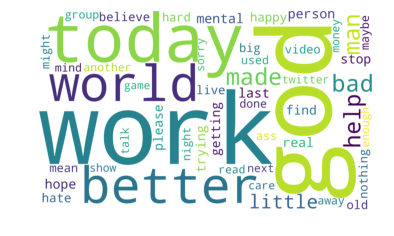

In [9]:
wc = WordCloud(background_color='white',
                  width=5000,
                  height=3000,
                  max_words=50).generate_from_frequencies(word_count)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
dictionary_non_agg = corpora.Dictionary(tweets)
dictionary_non_agg.compactify()

corpus_non_agg = [dictionary_non_agg.doc2bow(tweet) for tweet in tweets]
corpora.MmCorpus.serialize('corpus_non_agg.mm', corpus_non_agg)

In [12]:
corpus_filename = 'corpus.mm'
dict_filename   = 'tokens_dictionary.dict'
lda_filename    = 'LDA.lda'
lda_params      = {'num_topics': 30, 'passes': 50, 'alpha': 0.001}

In [14]:
# print("Running LDA with: %s  " % lda_params)

lda = models.LdaModel(corpus_non_agg, id2word=dictionary_non_agg,
                        num_topics=lda_params['num_topics'],
                        passes=lda_params['passes'],
                        alpha = lda_params['alpha'])

In [16]:
import warnings
warnings.filterwarnings('ignore')

topics_data =  pyLDAvis.gensim.prepare(lda, corpus_non_agg, dictionary_non_agg)
pyLDAvis.display(topics_data)